In [30]:
# Alternative: Using importlib.metadata (Python 3.8+)
import importlib.metadata
print("kaggle version:", importlib.metadata.version('kaggle'))

kaggle version: 1.7.4.5


In [ ]:
from google.colab import files
print("Please upload your 'kaggle.json' file.")
uploaded = files.upload()

Please upload your 'kaggle.json' file.


Saving kaggle.json to kaggle.json


In [3]:
import os
from pathlib import Path
import shutil
import stat

# Define the expected path for the uploaded kaggle.json in the current session directory
kaggle_file_source = 'kaggle.json'
kaggle_dir_dest = Path.home().joinpath('.kaggle')
kaggle_file_dest = kaggle_dir_dest.joinpath('kaggle.json')

# Create the .kaggle directory if it does not exist
kaggle_dir_dest.mkdir(parents=True, exist_ok=True)

try:
    # Move the kaggle.json file to the .kaggle directory
    shutil.move(kaggle_file_source, kaggle_file_dest)
    # Set permissions to secure the API key
    os.chmod(kaggle_file_dest, stat.S_IRUSR | stat.S_IWUSR)
    print(f"'{kaggle_file_source}' has been successfully moved to '{kaggle_file_dest}' and permissions set.")
except FileNotFoundError:
    print(f"Error: '{kaggle_file_source}' not found. Please ensure it was uploaded using 'files.upload()' in the previous step.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

'kaggle.json' has been successfully moved to '/root/.kaggle/kaggle.json' and permissions set.


In [4]:
#Download a Kaggle Dataset
!kaggle competitions download -c cmi-detect-behavior-with-sensor-data

  0% 0.00/178M [00:00<?, ?B/s]
100% 178M/178M [00:00<00:00, 3.14GB/s]


In [5]:
import zipfile

with zipfile.ZipFile("cmi-detect-behavior-with-sensor-data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")  # Extract to the current directory

## STEP 1: Load data and Merge train.csv and train_demographics.csv

In [6]:
import pandas as pd

# Load main data and demographics
train = pd.read_csv('train.csv')
demog = pd.read_csv('train_demographics.csv')

# Merge on 'subject'
train_full = train.merge(demog, on='subject', how='left')
print(train_full.shape)

(574945, 348)


## STEP 2: Data Cleaning

### A. Filter to Only 'Performs gesture' Sequences

In [7]:
gesture_df = train_full[train_full['behavior'] == 'Performs gesture'].copy()
print("Filtered to gesture rows:", gesture_df.shape)
#  Create a simplified label (8 BFRBs + 1 non_target)
gesture_df["gesture_slim"] = gesture_df.apply(
    lambda row: row["gesture"] if row["sequence_type"] == "Target" else "non_target", axis=1
)

Filtered to gesture rows: (255817, 348)


In [9]:
# Explicitly create a copy to avoid SettingWithCopyWarning
gesture_df = train_full[train_full['behavior'] == 'Performs gesture'].copy()
print("Filtered to gesture rows:", gesture_df.shape)

# Use a more memory-efficient approach to create the new column
# numpy.where is efficient but still requires a proper DataFrame object (not a view)
import numpy as np
gesture_df["gesture_slim"] = np.where(
    gesture_df["sequence_type"] == "Target",
    gesture_df["gesture"],
    "non_target"
)

# If the dataset is still too large, consider processing it in chunks
# or reducing the size of your dataset if possible

Filtered to gesture rows: (255817, 348)


### B. Missing Values

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Replace -1 in ToF columns with NaN for visualization
tof_cols = [col for col in gesture_df.columns if 'tof_' in col]
gesture_df[tof_cols] = gesture_df[tof_cols].replace(-1, pd.NA)

### C. Impute Missing Values

#### ToF, Thm : median imputation for classical ML

In [28]:
# Median imputation for ToF and Thermopile columns
for col in tof_cols:
    gesture_df[col] = pd.to_numeric(gesture_df[col], errors='coerce')
    gesture_df[col] = gesture_df[col].fillna(gesture_df[col].median())

thm_cols = [col for col in gesture_df.columns if 'thm_' in col]
for col in thm_cols:
    gesture_df[col] = gesture_df[col].fillna(gesture_df[col].median())

### D. Normalize Sensor Columns (z-score)

In [29]:
from sklearn.preprocessing import StandardScaler
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'rot_x', 'rot_y', 'rot_z'] + thm_cols + tof_cols
scaler = StandardScaler()
gesture_df[sensor_cols] = scaler.fit_transform(gesture_df[sensor_cols])

### E. Categorical Encoding

In [30]:
# One-hot encode sex and handedness
gesture_df = pd.get_dummies(gesture_df, columns=['sex', 'handedness'], drop_first=True)

KeyError: "None of [Index(['sex', 'handedness'], dtype='object')] are in the [columns]"

## STEP 3: Feature Extraction from Time-Series

### A. Rolling Features Example (e.g., rolling mean for 'acc_y', 'acc_z', 'rot_x', 'rot_y', 'rot_z)

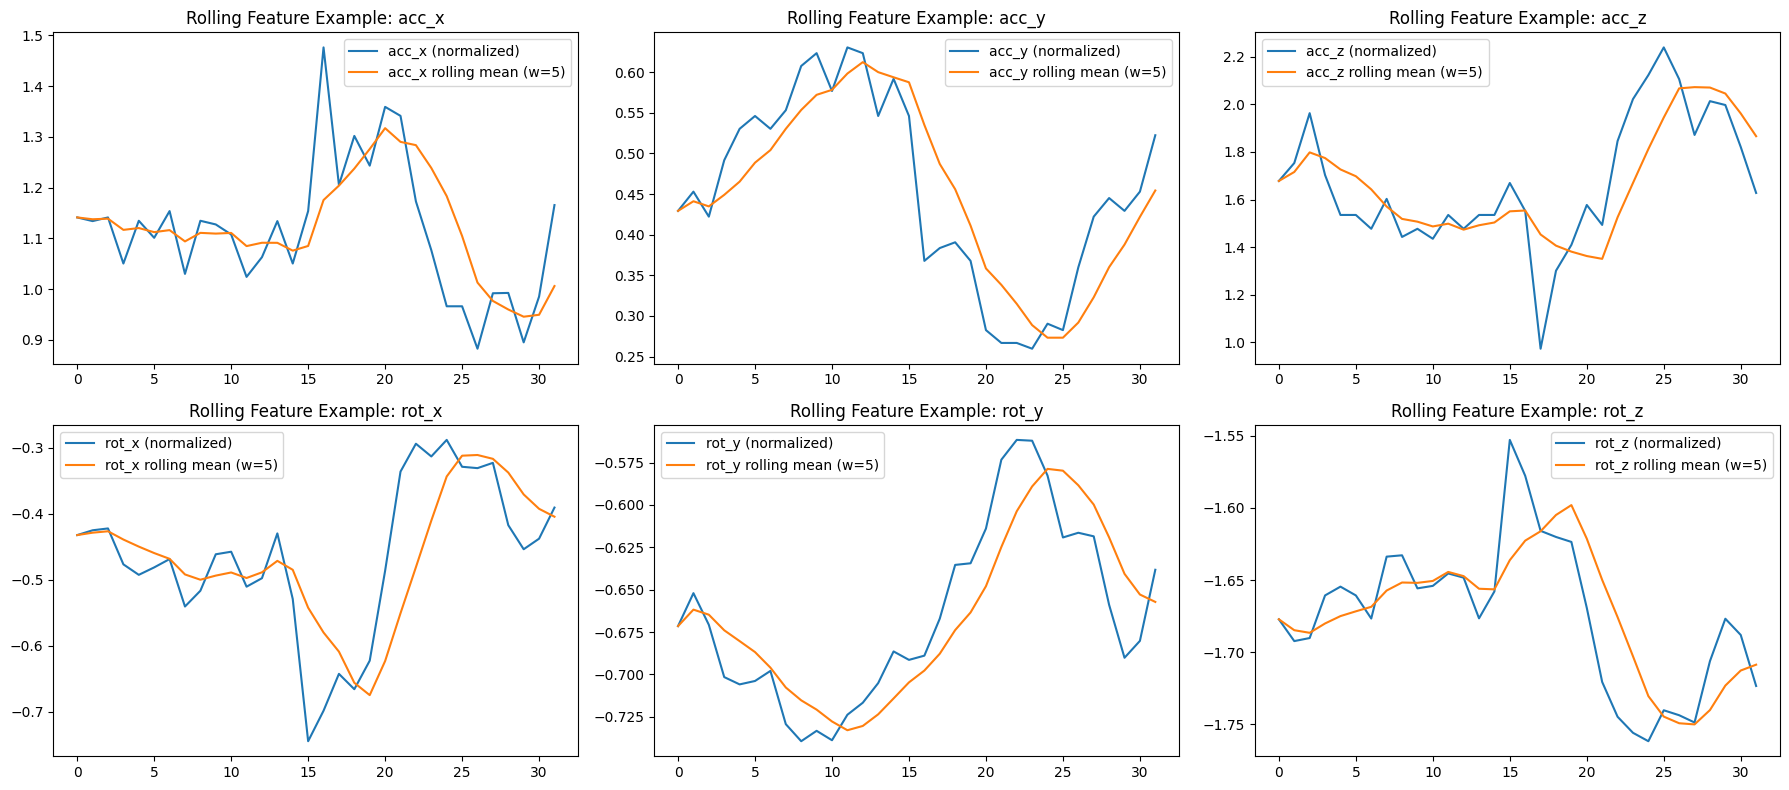

In [17]:
import matplotlib.pyplot as plt

# List of variables to plot
vars_to_plot = ['acc_x', 'acc_y', 'acc_z', 'rot_x', 'rot_y', 'rot_z']
window_size = 5

# Pick a sequence (change index as needed)
seq = gesture_df[gesture_df['sequence_id'] == gesture_df['sequence_id'].iloc[5]].copy()

# Set up the subplot grid
fig, axs = plt.subplots(2, 3, figsize=(18, 8))  # 2 rows, 3 columns

for i, var in enumerate(vars_to_plot):
    ax = axs[i // 3, i % 3]
    seq[f'{var}_rolling_mean'] = seq[var].rolling(window=window_size, min_periods=1).mean()
    ax.plot(seq[var].values, label=f'{var} (normalized)')
    ax.plot(seq[f'{var}_rolling_mean'].values, label=f'{var} rolling mean (w={window_size})')
    ax.set_title(f'Rolling Feature Example: {var}')
    ax.legend()

plt.tight_layout()
plt.show()

### B. FFT Feature Example

In [18]:
import numpy as np

def fft_features(x):
    fft_vals = np.abs(np.fft.fft(x.fillna(0)))
    return {
        'fft_max': fft_vals.max(),
        'fft_mean': fft_vals.mean(),
        'fft_std': fft_vals.std(),
        'fft_energy': np.sum(fft_vals**2)
    }

# Compute FFT features for acc_x of a sequence
acc_x_vals = seq['acc_x'].values
fft_feats = fft_features(pd.Series(acc_x_vals))
print("FFT Features for acc_x:", fft_feats)

FFT Features for acc_x: {'fft_max': np.float64(35.70012652420725), 'fft_mean': np.float64(1.6831100606169282), 'fft_std': np.float64(6.126175314822397), 'fft_energy': np.float64(1291.6122708508556)}


#### Plot acc_x before and after FFT (spectrum)

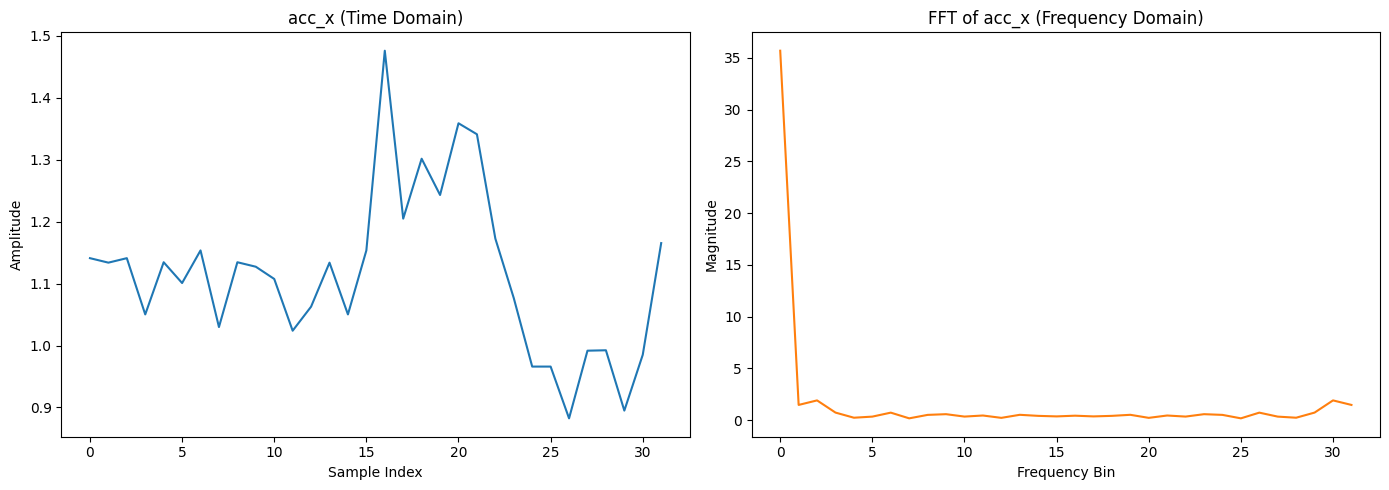

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Example acc_x_vals
# acc_x_vals = ...

fft_mag = np.abs(np.fft.fft(acc_x_vals))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Time domain plot
axs[0].plot(acc_x_vals, color='tab:blue')
axs[0].set_title('acc_x (Time Domain)')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Amplitude')

# Frequency domain plot
axs[1].plot(fft_mag, color='tab:orange')
axs[1].set_title('FFT of acc_x (Frequency Domain)')
axs[1].set_xlabel('Frequency Bin')
axs[1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()

### C. Aggregate Features for ML

##### Let’s summarize each sequence to one row (per-sequence mean, std, etc.)

In [20]:
def extract_agg_features(df):
    feats = {}
    for col in sensor_cols:
        feats[f'{col}_mean'] = df[col].mean()
        feats[f'{col}_std'] = df[col].std()
        feats[f'{col}_min'] = df[col].min()
        feats[f'{col}_max'] = df[col].max()
    # Add demographic features (assume only one subject per sequence)
    for dcol in ['age', 'height_cm', 'elbow_to_wrist_cm', 'shoulder_to_wrist_cm', 'sex_1', 'handedness_1']:
        feats[dcol] = df[dcol].iloc[0]
    # Optionally FFT features for acc_x
    fft_feats = fft_features(df['acc_x'])
    for k, v in fft_feats.items():
        feats[f'acc_x_{k}'] = v
    return pd.Series(feats)

#agg_features = gesture_df.groupby('sequence_id').apply(extract_agg_features)
agg_features = gesture_df.groupby('sequence_id', group_keys=False).apply(extract_agg_features)

print(agg_features.head())

             acc_x_mean  acc_x_std  acc_x_min  acc_x_max  acc_y_mean  \
sequence_id                                                            
SEQ_000007     1.115629   0.131344   0.882461   1.476211    0.452838   
SEQ_000008     0.538312   0.124149   0.249216   0.790963    0.780206   
SEQ_000013    -1.322289   0.192727  -1.601807  -0.923801    0.071486   
SEQ_000016     0.848658   0.158421   0.607309   1.537429   -1.644155   
SEQ_000018     1.007743   0.040648   0.920640   1.108244    0.539377   

             acc_y_std  acc_y_min  acc_y_max  acc_z_mean  acc_z_std  ...  age  \
sequence_id                                                          ...        
SEQ_000007    0.117557   0.259687   0.630411    1.666621   0.273412  ...   12   
SEQ_000008    0.166410   0.266786   1.064235    1.970780   0.381472  ...   24   
SEQ_000013    0.115359  -0.149686   0.259687   -0.470500   0.212250  ...   12   
SEQ_000016    0.089185  -1.840814  -1.314703   -0.729260   0.425567  ...   13   
SEQ_00001

/tmp/ipython-input-3060186739.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_features = gesture_df.groupby('sequence_id', group_keys=False).apply(extract_agg_features)


## STEP 4: Modeling

### Prepare ML Data

In [32]:
from sklearn.preprocessing import LabelEncoder

# Assign gesture_slim at the sequence level to agg_features, so index is sequence_id
agg_features['gesture_slim'] = gesture_df.groupby('sequence_id')['gesture_slim'].first()

# Drop rows where gesture_slim is missing (if any)
agg_features = agg_features.dropna(subset=['gesture_slim'])

# Multiclass label encoding (0-8 for 9 classes)
le = LabelEncoder()
y_multi = le.fit_transform(agg_features['gesture_slim'])  # array, shape (n_sequences,)

# Multiclass labels as text
y_multi_labels = agg_features['gesture_slim']

# Binary label: 1 = BFRB, 0 = non-BFRB
y_bin = (y_multi_labels != 'non_target').astype(int)

# Now, build your feature matrix X, removing non-feature columns (like gesture_slim, etc.)
# For example, if you want to drop all columns that aren't features:
exclude_cols = ['gesture_slim']  # add any others you don't want in X
X = agg_features.drop(columns=exclude_cols)

# Confirm alignment
assert all(X.index == agg_features.index)  # Should be True
assert len(X) == len(y_bin) == len(y_multi)

# Inspect label distributions
print("Binary label distribution:\n", y_bin.value_counts())
print("Multiclass label distribution:\n", y_multi_labels.value_counts())

Binary label distribution:
 gesture_slim
1    5113
0    3037
Name: count, dtype: int64
Multiclass label distribution:
 gesture_slim
non_target                  3037
Eyelash - pull hair          640
Forehead - pull hairline     640
Neck - scratch               640
Neck - pinch skin            640
Forehead - scratch           640
Eyebrow - pull hair          638
Above ear - pull hair        638
Cheek - pinch skin           637
Name: count, dtype: int64


In [33]:
from sklearn.model_selection import train_test_split

# For binary task
X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(
    X, y_bin, test_size=0.2, stratify=y_bin, random_state=42
)

# For multiclass task
X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(
    X, y_multi, test_size=0.2, stratify=y_multi, random_state=42
)

### Missing values check

In [34]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

X_train_bin_imputed = pd.DataFrame(imputer.fit_transform(X_train_bin), columns=X_train_bin.columns, index=X_train_bin.index)
X_val_bin_imputed = pd.DataFrame(imputer.transform(X_val_bin), columns=X_val_bin.columns, index=X_val_bin.index)

X_train_multi_imputed = pd.DataFrame(imputer.fit_transform(X_train_multi), columns=X_train_multi.columns, index=X_train_multi.index)
X_val_multi_imputed = pd.DataFrame(imputer.transform(X_val_multi), columns=X_val_multi.columns, index=X_val_multi.index)

# Confirm again
print("After imputation - missing in X_train_bin:", X_train_bin_imputed.isnull().sum().sum())
print("After imputation - missing in X_val_bin:", X_val_bin_imputed.isnull().sum().sum())
print("After imputation - missing in X_train_multi:", X_train_multi_imputed.isnull().sum().sum())
print("After imputation - missing in X_val_multi:", X_val_multi_imputed.isnull().sum().sum())

After imputation - missing in X_train_bin: 0
After imputation - missing in X_val_bin: 0
After imputation - missing in X_train_multi: 0
After imputation - missing in X_val_multi: 0


### A. Random Forest

#### a. Binary Classification (BFRB vs non-BFRB)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, log_loss, accuracy_score

# Binary
rf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bin.fit(X_train_bin_imputed, y_train_bin)
y_pred_bin = rf_bin.predict(X_val_bin_imputed)
y_proba_bin = rf_bin.predict_proba(X_val_bin_imputed)

print("Random Forest (Binary)\n", classification_report(y_val_bin, y_pred_bin))
print("Accuracy:", accuracy_score(y_val_bin, y_pred_bin))
print("Log loss:", log_loss(y_val_bin, y_proba_bin))

Random Forest (Binary)
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       607
           1       0.96      0.98      0.97      1023

    accuracy                           0.96      1630
   macro avg       0.97      0.96      0.96      1630
weighted avg       0.96      0.96      0.96      1630

Accuracy: 0.9638036809815951
Log loss: 0.20239687082753655


#### b. Multiclass Classification (Specific Gesture)

In [36]:
# Multiclass
rf_multi = RandomForestClassifier(n_estimators=150, random_state=42)
rf_multi.fit(X_train_multi_imputed, y_train_multi)
y_pred_multi = rf_multi.predict(X_val_multi_imputed)
y_proba_multi = rf_multi.predict_proba(X_val_multi_imputed)

print("Random Forest (Multiclass)\n", classification_report(y_val_multi, y_pred_multi, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_val_multi, y_pred_multi))
print("Log loss:", log_loss(y_val_multi, y_proba_multi))

Random Forest (Multiclass)
                           precision    recall  f1-score   support

   Above ear - pull hair       0.75      0.59      0.66       128
      Cheek - pinch skin       0.55      0.57      0.56       127
     Eyebrow - pull hair       0.62      0.52      0.56       128
     Eyelash - pull hair       0.66      0.48      0.55       128
Forehead - pull hairline       0.67      0.64      0.66       128
      Forehead - scratch       0.68      0.75      0.71       128
       Neck - pinch skin       0.56      0.51      0.53       128
          Neck - scratch       0.55      0.56      0.56       128
              non_target       0.86      0.98      0.91       607

                accuracy                           0.73      1630
               macro avg       0.66      0.62      0.63      1630
            weighted avg       0.72      0.73      0.72      1630

Accuracy: 0.7257668711656442
Log loss: 0.9171047227544408


### B. XGBoost Model

#### a. Binary Classification (BFRB vs non-BFRB)

In [37]:
from xgboost import XGBClassifier

xgb_bin = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    eval_metric='logloss',
    random_state=42
)

xgb_bin.fit(X_train_bin_imputed, y_train_bin)
y_pred_bin_xgb = xgb_bin.predict(X_val_bin_imputed)
y_proba_bin_xgb = xgb_bin.predict_proba(X_val_bin_imputed)

print("XGBoost (Binary)\n", classification_report(y_val_bin, y_pred_bin_xgb))
print("Accuracy:", accuracy_score(y_val_bin, y_pred_bin_xgb))
print("Log loss:", log_loss(y_val_bin, y_proba_bin_xgb))

XGBoost (Binary)
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       607
           1       0.98      0.99      0.98      1023

    accuracy                           0.98      1630
   macro avg       0.98      0.97      0.97      1630
weighted avg       0.98      0.98      0.98      1630

Accuracy: 0.9766871165644172
Log loss: 0.07003709746623898


#### b. Multiclass Classification (Specific Gesture)

In [39]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost expects numeric labels for multiclass
# If y_train_multi and y_val_multi are already 0-based integers, you're good.

# Convert data to DMatrix (optional, but recommended for speed)
dtrain = xgb.DMatrix(X_train_multi_imputed, label=y_train_multi)
dval = xgb.DMatrix(X_val_multi_imputed, label=y_val_multi)

# Set parameters for multiclass classification
num_classes = len(le.classes_)
params = {
    'objective': 'multi:softprob',
    'num_class': num_classes,
    'eval_metric': 'mlogloss',
    'random_state': 42,
    'max_depth': 6,
    'learning_rate': 0.1
}

# Train the model
model_xgb = xgb.train(
    params,
    dtrain,
    num_boost_round=150,
    evals=[(dval, 'eval')],
    early_stopping_rounds=10,
    verbose_eval=False
)

# Predict
y_pred_prob_xgb = model_xgb.predict(dval)
y_pred_xgb = y_pred_prob_xgb.argmax(axis=1) # Corrected variable name here

# Evaluation
print("XGBoost (Multiclass)\n", classification_report(y_val_multi, y_pred_xgb, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_val_multi, y_pred_xgb))
print("Log loss:", log_loss(y_val_multi, y_pred_prob_xgb))

XGBoost (Multiclass)
                           precision    recall  f1-score   support

   Above ear - pull hair       0.85      0.77      0.81       128
      Cheek - pinch skin       0.66      0.69      0.67       127
     Eyebrow - pull hair       0.54      0.55      0.55       128
     Eyelash - pull hair       0.64      0.54      0.59       128
Forehead - pull hairline       0.73      0.70      0.72       128
      Forehead - scratch       0.74      0.77      0.75       128
       Neck - pinch skin       0.58      0.55      0.56       128
          Neck - scratch       0.59      0.64      0.62       128
              non_target       0.95      0.99      0.97       607

                accuracy                           0.78      1630
               macro avg       0.70      0.69      0.69      1630
            weighted avg       0.77      0.78      0.77      1630

Accuracy: 0.7754601226993865
Log loss: 0.616994207775882


## STEP 6: Evaluation Protocol

##### Use classification_report to see accuracy, precision, recall, f1-score for each model.

##### Plot and compare confusion matrices for further insight.

##### If you want multi-class (specific gesture) modeling, simply set y = bfrb_ids.loc[agg_features.index] (no binarization) and repeat above.

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(y_true_bin, y_pred_bin, y_true_multi, y_pred_multi, class_names_multi = le.classes_, model_name="Model"):
    # 1. Binary classification report & F1
    print(f"=== {model_name}: BINARY CLASSIFICATION ===")
    print(classification_report(y_true_bin, y_pred_bin, target_names=['non-BFRB', 'BFRB']))
    f1_bin = f1_score(y_true_bin, y_pred_bin, average='binary')
    print(f"Binary F1-score: {f1_bin:.4f}")
    print(f"Binary Accuracy: {accuracy_score(y_true_bin, y_pred_bin):.4f}\n")

    # Plot binary confusion matrix
    plt.figure(figsize=(4,4))
    cm_bin = confusion_matrix(y_true_bin, y_pred_bin)
    sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues',
                xticklabels=['non-BFRB', 'BFRB'],
                yticklabels=['non-BFRB', 'BFRB'])
    plt.title(f"{model_name} - Binary Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # 2. Multiclass classification report & macro F1
    print(f"=== {model_name}: MULTICLASS CLASSIFICATION ===")
    print(classification_report(y_true_multi, y_pred_multi, target_names=class_names_multi))
    f1_macro = f1_score(y_true_multi, y_pred_multi, average='macro')
    print(f"Macro F1-score: {f1_macro:.4f}")
    print(f"Multiclass Accuracy: {accuracy_score(y_true_multi, y_pred_multi):.4f}\n")

    # Plot multiclass confusion matrix
    plt.figure(figsize=(8,6))
    cm_multi = confusion_matrix(y_true_multi, y_pred_multi)
    sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_multi, yticklabels=class_names_multi)
    plt.title(f"{model_name} - Multiclass Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # 3. Composite competition metric
    final_score = 0.5 * (f1_bin + f1_macro)
    print(f"=== {model_name}: FINAL COMPOSITE SCORE ===")
    print(f"Final competition score: {final_score:.4f}\n")
    return {'F1_binary': f1_bin, 'F1_macro': f1_macro, 'Final_score': final_score}


### A. Random Forest

=== Random Forest: BINARY CLASSIFICATION ===
              precision    recall  f1-score   support

    non-BFRB       0.97      0.93      0.95       607
        BFRB       0.96      0.98      0.97      1023

    accuracy                           0.96      1630
   macro avg       0.97      0.96      0.96      1630
weighted avg       0.96      0.96      0.96      1630

Binary F1-score: 0.9715
Binary Accuracy: 0.9638



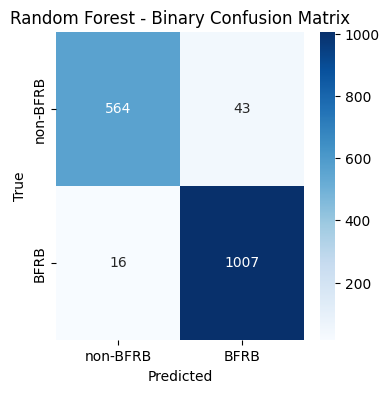

=== Random Forest: MULTICLASS CLASSIFICATION ===
                          precision    recall  f1-score   support

   Above ear - pull hair       0.75      0.59      0.66       128
      Cheek - pinch skin       0.55      0.57      0.56       127
     Eyebrow - pull hair       0.62      0.52      0.56       128
     Eyelash - pull hair       0.66      0.48      0.55       128
Forehead - pull hairline       0.67      0.64      0.66       128
      Forehead - scratch       0.68      0.75      0.71       128
       Neck - pinch skin       0.56      0.51      0.53       128
          Neck - scratch       0.55      0.56      0.56       128
              non_target       0.86      0.98      0.91       607

                accuracy                           0.73      1630
               macro avg       0.66      0.62      0.63      1630
            weighted avg       0.72      0.73      0.72      1630

Macro F1-score: 0.6348
Multiclass Accuracy: 0.7258



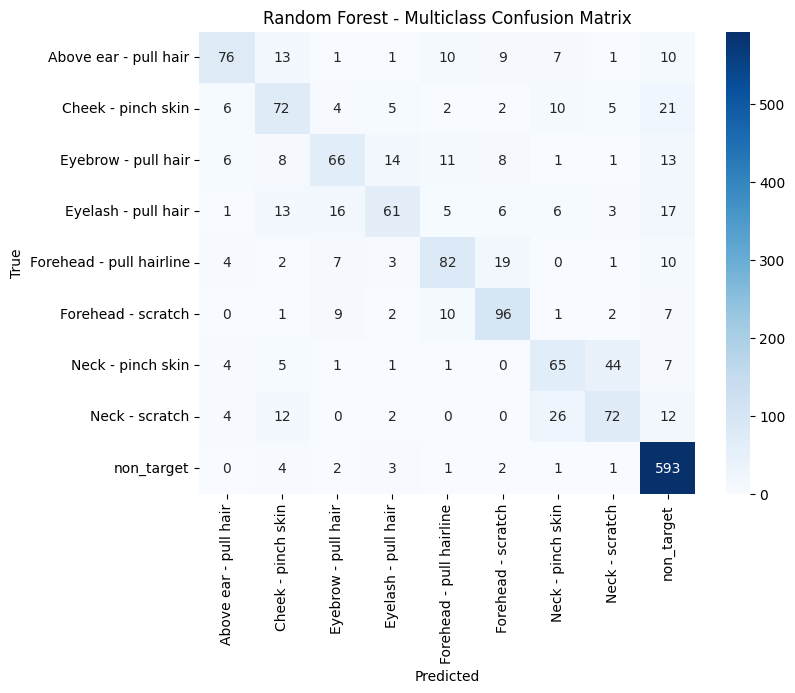

=== Random Forest: FINAL COMPOSITE SCORE ===
Final competition score: 0.8032



{'F1_binary': 0.9715388326097444,
 'F1_macro': 0.6347772821705914,
 'Final_score': 0.8031580573901679}

In [42]:
evaluate_model(y_val_bin, y_pred_bin, y_val_multi, y_pred_multi, class_names_multi = le.classes_, model_name="Random Forest")

### B. XGBoost Model

=== XGBoost Model: BINARY CLASSIFICATION ===
              precision    recall  f1-score   support

    non-BFRB       0.98      0.96      0.97       607
        BFRB       0.98      0.99      0.98      1023

    accuracy                           0.98      1630
   macro avg       0.98      0.97      0.97      1630
weighted avg       0.98      0.98      0.98      1630

Binary F1-score: 0.9815
Binary Accuracy: 0.9767



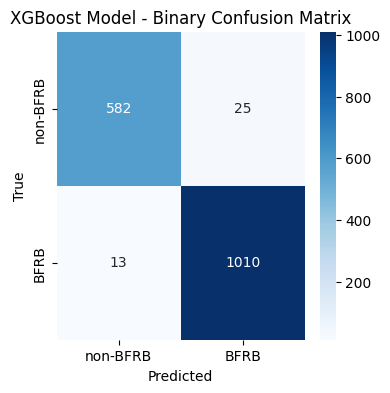

=== XGBoost Model: MULTICLASS CLASSIFICATION ===
                          precision    recall  f1-score   support

   Above ear - pull hair       0.85      0.77      0.81       128
      Cheek - pinch skin       0.66      0.69      0.67       127
     Eyebrow - pull hair       0.54      0.55      0.55       128
     Eyelash - pull hair       0.64      0.54      0.59       128
Forehead - pull hairline       0.73      0.70      0.72       128
      Forehead - scratch       0.74      0.77      0.75       128
       Neck - pinch skin       0.58      0.55      0.56       128
          Neck - scratch       0.59      0.64      0.62       128
              non_target       0.95      0.99      0.97       607

                accuracy                           0.78      1630
               macro avg       0.70      0.69      0.69      1630
            weighted avg       0.77      0.78      0.77      1630

Macro F1-score: 0.6925
Multiclass Accuracy: 0.7755



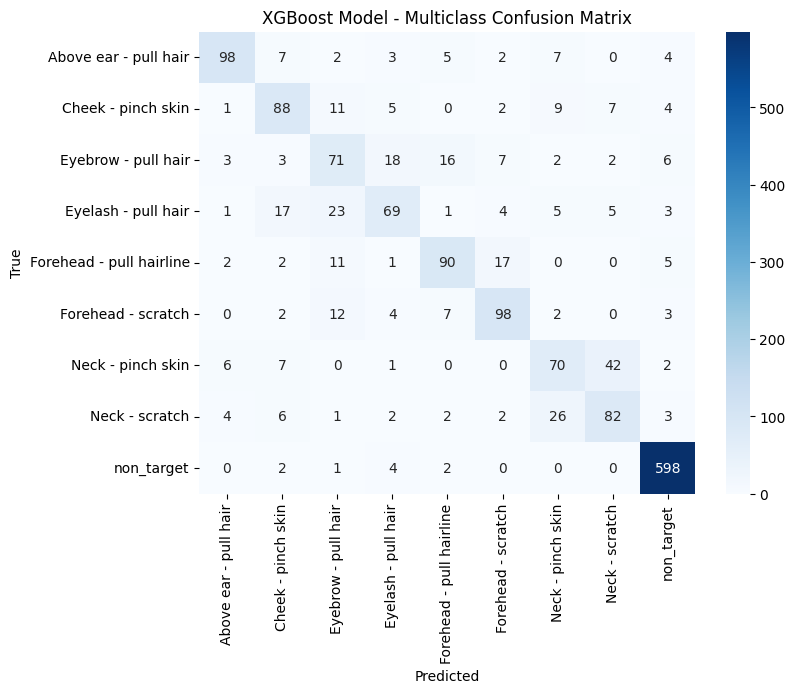

=== XGBoost Model: FINAL COMPOSITE SCORE ===
Final competition score: 0.8370



{'F1_binary': 0.9815354713313897,
 'F1_macro': 0.6924989758568196,
 'Final_score': 0.8370172235941047}

In [41]:
evaluate_model(y_val_bin, y_pred_bin_xgb, y_val_multi, y_pred_xgb, class_names_multi = le.classes_, model_name="XGBoost Model")